In [1]:
import numpy as np         
import pandas as pd
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

/Users/mortonjt/miniconda3/envs/edward/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/mortonjt/miniconda3/envs/edward/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# helper function to perform sparse matrix multiplication
def sparse_matmul(A, B, row_index, col_index):
    """ Sparse matrix multiplication.

    This will try to evaluate the following product

    A[i] @ B[j]

    where i, j are the row and column indices specified in `indices`.

    Parameters
    ----------
    A : tf.Tensor
       Left 2D tensor
    B : tf.Tensor
       Right 2D tensor
    row_idx : tf.Tensor
       Row indexes to access in A
    col_idx : tf.Tensor
       Column indexes to access in B


    Returns
    -------
    tf.Tensor
       Result stored in a sparse tensor format, where the values
       are derived from A[i] @ B[j] where i, j are the row and column
       indices specified in `indices`.
    """
    A_flat = tf.gather(A, row_index, axis=0)
    B_flat = tf.transpose(tf.gather(B, col_index, axis=1))
    values = tf.reduce_sum(tf.multiply(A_flat, B_flat), axis=1)
    return values

def chain_interactions(gradient, mu, sigma):
    """
    This generates an urn simulating a chain of interacting species.

    This commonly occurs in the context of a redox tower, where
    multiple species are distributed across a gradient.

    Parameters
    ----------
    gradient: array_like
       Vector of values associated with an underlying gradient.
    mu: array_like
       Vector of means.
    sigma: array_like
       Vector of standard deviations.
    rng: np.random.RandomState
       Numpy random state.

    Returns
    -------
    np.array
       A matrix of real-valued positive abundances where
       there are `n` rows and `m` columns where `n` corresponds
       to the number of samples along the `gradient` and `m`
       corresponds to the number of species in `mus`.
    """
    xs = [norm.pdf(gradient, loc=mu[i], scale=sigma[i])
          for i in range(len(mu))]
    return np.vstack(xs).T


# Simulation

First let's provide some motivation behind performing linear regression on log ratios.

In ecological studies, it was observed that microbial species abundances tend to follow unimodal distributions 
across environment gradients (i.e. pH, oxygen, ...).  

If make a simplifying assumption that these species abundance distributions can be modeled by Gaussian distributions
with equal variance, then the log ratio between these distributions follows a linear relationship.  The intuition behind this is shown in the following code and figures.

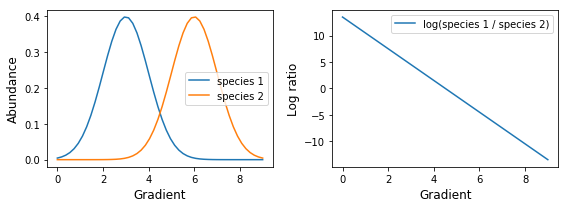

In [3]:
from bayesian_regression.util.sim import chain_interactions

g = np.linspace(0, 9, 50)   # gradient values
mu = [3, 6]                 # means of species abundance gaussian distributions
sigma = [1, 1]              # variances of species abundance gaussian distribution
x = chain_interactions(g, mu, sigma)

# Plot the distributions and log-ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(g, x[:, 0], label='species 1') 
ax1.plot(g, x[:, 1], label='species 2')
ax2.plot(g, np.log(x[:, 0] / x[:, 1]), label='log(species 1 / species 2)')
ax1.legend() 
ax2.legend()
ax1.set_xlabel('Gradient', fontsize=12)
ax1.set_ylabel('Abundance', fontsize=12)
ax2.set_xlabel('Gradient', fontsize=12)
ax2.set_ylabel('Log ratio', fontsize=12)
plt.tight_layout()

Now let's extend this idea to more species.  From this concept, we can build a generative model that can simultaneously explain the underlying biology, while generating data that looks like realistic observed microbial counts.

The model will be constructed as follows

Generate Principal components with singular value matrices U and V

$\phi = U V^T$

$phi$ represents the log ratios (also known as logits) of the species.  These logits can ultimately be used to interpret trends of ecological succession amongst groups of species.  However, these log ratios cannot be directly estimated (since it isn't possible to take the logarithm of zero).  Instead, we will rely on the generative process, and convert these log ratios to proportions, before generating counts.

$\phi$ can be converted to proportions using the ILR transform.  $\phi$ has $D-1$ dimensions, where $D$ is the number of species.  The ILR transform can be represented as follows

$\eta = \Psi \phi$

where $\Psi$ is an orthonormal basis of dimensions $D \times D-1$.  It is possible to encode a tree topology into $\Psi$.  One approach is to take phylogenetic trees in order to infer evolutionary trends with respect to environmental gradients.  For the sake of simplicity, we will choose an arbituary tree.  In terms of generating microbial counts, the choice tree doesn't matter since all trees will generate orthonormal bases that are equivalent up to rotation.

Once we have proportions estimated by $\eta$, we can then use these proportions to parameterize a counting distribution, such as the Multinomial distribution, the Poisson distribution or the Negative Binomial distribution.

Here we will use the Poisson distribution to simulate microbial counts.  In order to account or differences due to sequencing depth and additional sample biases, a bias constant $\theta$ is added to the model.

$Y \sim Poisson( exp(\eta + \theta) )$

To evaluate how well the model fits, we will first provide fixed estimates of $B$ by stacking shifted Gaussian distributions.  We will then simulate microbial counts using the generative model that we have specified above.
If the model works, we should be able to recover the underlying parameters, and regenerate the microbial count table.

One thing to note is that the gradients that will be feed into the regression are zero centered.  This is very important for fitting a proper regression (possibly due to the choice of priors).  It is much harder to get sane results if the metadata aren't centered.  It may be worthwhile to also scale the results.

Text(0.5,1,'Simulation')

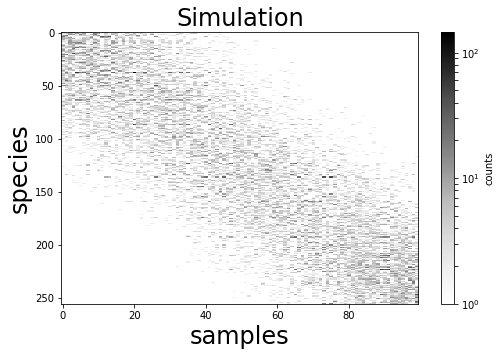

In [4]:
from bayesian_regression.util.generators import band_table
from skbio.stats.composition import _gram_schmidt_basis
from scipy.sparse import coo_matrix
from gneiss.cluster import random_linkage

num_samples = 100
num_features = 256

# Build basis for the ilr transform. 
basis = coo_matrix(_gram_schmidt_basis(num_features), dtype=np.float32).T

# the definition of low / high is important.  If the input is not centered, 
# it will be harder to reach convergence.  So it is more ideal to center the 
# covariates before running the regression.  This is similar to batch normalization.
table, metadata, sim_beta, sim_theta, sim_gamma = band_table(
    num_samples, num_features, 
    low=-5, high=5, sigma=2, alpha=6, seed=0)

# Plot the heatmap of the counts
fig = plt.figure(figsize=(8, 5))
plt.imshow(table.matrix_data.todense(), aspect='auto', cmap='Greys', norm=colors.LogNorm())
plt.colorbar(label='counts')
plt.ylabel('species', fontsize=24)
plt.xlabel('samples', fontsize=24)
plt.title('Simulation', fontsize=24) 

# Model

This is where we will specify the model.  Specifically



$v_{ij} = \alpha + \theta_i + \gamma_j + u_{i.} \cdot v_{.j}$

$\eta_i = \Psi v_i$

$Y_i \sim Poisson( \exp(\eta_i) )$

G and Y are both observed.  Since we are estimating both $B$ and $\theta$, we will need set priors for both of these variables.  We will set unit normal priors on both of these variables

In [5]:
# Priors
alpha_mean = 0
alpha_scale = 5
theta_mean = 0
theta_scale = 5
gamma_mean = 0
gamma_scale = 5
beta_mean = 0
beta_scale = 1

# Mini batch size
batch_size = 1000 

We will build the model using mini-batch stochastic gradient descent.  This done for two reasons : (1) to ensure faster convergence and (2) to take advantage of the inherient sparsity in microbiome datasets.

Microbiome datasets are very sparse, analogous to word counts in a document.  There may be as few as 1% of the entries in the matrix are nonzero.  To represent the matrix in a sparse format, we will us a COO-format.  The observed matrix will be represented as (i, j, data_ij) coordinates, where i represent row index, j represents column index, and data_ij represents the data value in the (i, j) index.  This will ultimately allow us to focus on performing inference on the non-zero values.

As a part of the mini-batch gradient descent, we will do bootstrapping technique.  In our case we will select 1000 entries.  Of those 1000 entries, half of those entries will correspond to non-zero values, and the remaining half correspond to zeros in the matrix.  This is to balance the parameter estimation, so that we don't bias the parameter estimates only to the nonzero values.  This is a commonly used technique in recommender systems when one can only rely on positive observed values.

In [6]:
from bayesian_regression.util.model import sparse_matmul
from bayesian_regression.util.balances import ilr_to_clr
from edward.models import Normal, Poisson

N, D = num_samples, num_features
p = metadata.shape[1]   # number of covariates

# dummy variables for mini-batch size
batch_row = tf.placeholder(tf.int32, shape=[batch_size], name='batch_i')
batch_col = tf.placeholder(tf.int32, shape=[batch_size], name='batch_j')

# global bias
alpha = Normal(loc=tf.zeros([]) + alpha_mean,
               scale=tf.ones([]) * alpha_scale,
               name='alpha')
# sample bias                                                                                    
theta = Normal(loc=tf.zeros([N, 1]) + theta_mean,
               scale=tf.ones([N, 1]) * theta_scale,
               name='theta')
# species bias
gamma = Normal(loc=tf.zeros([1, D-1]) + gamma_mean,
               scale=tf.ones([1, D-1]) * gamma_scale, 
               name='gamma')

# Specify sample principal axes
U = Normal(loc=tf.zeros([N, p]),
           scale=tf.ones([N, p]),
           name='U')
Uprime = tf.concat([theta, tf.ones([N, 1]), U], axis=1)
# Specify feature principal axes
V = Normal(loc=tf.zeros([p, D-1]),
           scale=tf.ones([p, D-1]), 
           name='V')
Vprime = tf.concat([tf.ones([1, D-1]), gamma, V], axis=0)


# Convert basis to SparseTensor
psi = tf.SparseTensor(
    indices=np.mat([basis.row, basis.col]).transpose(),
    values=basis.data,
    dense_shape=basis.shape)

# clr transform coefficients first                                                               
cV = ilr_to_clr(Vprime, psi)
# retrieve entries selected by index
eta = sparse_matmul(
    Uprime, cV, 
    row_index=batch_row, col_index=batch_col
)
# obtain counts                                          
Y = Poisson( rate=tf.exp(eta + alpha), name='Y' ) 

# Inference

We will perform inference using MAP utilizing the ADAM optimizer.

In [7]:
from edward.models import PointMass

# Learning parameters
learning_rate = 1e-1
beta1 = 0.9
beta2 = 0.99
iterations = 3000

# initialize the summaries
summary_dir = 'summary-dir'

Since we are doing Variational inference, the posterior distribution is represented as normal distributions

In [8]:
# These are the posterior distributions.
tf.set_random_seed(0)

qalpha_vars = [tf.get_variable("qalpha/loc", []),
               tf.get_variable("qalpha/scale", [])]
qalpha = Normal(loc=qalpha_vars[0],
                scale=tf.nn.softplus(qalpha_vars[1]))

qgamma_vars = [tf.get_variable("qgamma/loc", [1, D-1]),
               tf.get_variable("qgamma/scale", [1, D-1])]
qgamma = Normal(loc=qgamma_vars[0],
                scale=tf.nn.softplus(qgamma_vars[1]))

qtheta_vars = [tf.get_variable("qtheta/loc", [N, 1]),
               tf.get_variable("qtheta/scale", [N, 1])]
qtheta = Normal(loc=qtheta_vars[0],
                scale=tf.nn.softplus(qtheta_vars[1]))

qU_vars = [tf.get_variable("qU/loc", [N, p]),
           tf.get_variable("qU/scale", [N, p])]
qU = Normal(loc=qU_vars[0],
            scale=tf.nn.softplus(qU_vars[1]))

qV_vars = [tf.get_variable("qV/loc", [p, D-1]),
           tf.get_variable("qV/scale", [p, D-1])]
qV = Normal(loc=qV_vars[0],
            scale=tf.nn.softplus(qV_vars[1]))

# a placeholder for the microbial counts
# since we will be manually feeding it into the inference via minibatch SGD
Y_ph = tf.placeholder(tf.float32, shape=[batch_size], name='Y_placeholder')

inference_u = ed.KLqp({
    U: qU,
    theta: qtheta,
    alpha: qalpha,
    gamma: qgamma}, 
    data={Y: Y_ph, V: qV})
inference_v = ed.KLqp({
    V: qV,
    theta: qtheta,
    alpha: qalpha,
    gamma: qgamma}, 
    data={Y: Y_ph, U: qU})

inference_u.initialize(var_list=qU_vars + qalpha_vars + qtheta_vars,
                       n_samples=5,                       
                       logdir=summary_dir
                      )

inference_v.initialize(var_list=qV_vars + qalpha_vars + qgamma_vars,
                       n_samples=5,
                       logdir=summary_dir
                      )

# adds checks for nans
tf.add_check_numerics_ops()

# initialize all tensorflow variables
sess = ed.get_session()
tf.global_variables_initializer().run()

We will create some helper variables to better keep track of progress.

In [9]:
losses = np.array([0.] * iterations)
errors = np.array([0.] * iterations)

data = table.matrix_data.tocoo().T

y_row, y_col, y_data = data.row, data.col, data.data

Now we will perform inference.  We will randomly bootstrap entries at every step of the iteration and
evaluate the MSE between the observed and predicted entries.

In [10]:
from bayesian_regression.util.inference import get_batch

for i in range(iterations):
    if not np.any(np.isnan(sess.run(qU.mean()))):
        u_ = sess.run(qU.mean())
        v_ = sess.run(qV.mean())
        theta_ = sess.run(qtheta.mean())
        gamma_ = sess.run(qgamma.mean())
        alpha_ = sess.run(qalpha.mean())
        
        log_u = ((u_ @ v_ + theta_).T + gamma_.T + alpha_).T @ basis.T
        err = np.mean((np.exp(log_u[y_row, y_col]) - y_data).ravel() ** 2)
        errors[i] = err
        
    # get batches
    idx_row, idx_col, idx_data = get_batch(M=batch_size, Y=data)

    inference_u.update(
        feed_dict={batch_row: idx_row, batch_col: idx_col, Y_ph: idx_data})
    info_dict = inference_v.update(
        feed_dict={batch_row: idx_row, batch_col: idx_col, Y_ph: idx_data})
    inference_v.print_progress(info_dict)
    losses[i] = info_dict['loss']

 470/1000 [ 47%] ██████████████                 ETA: 755s | Loss: 2943.666

KeyboardInterrupt: 

Text(0.5,1,'Mean Squared Error')

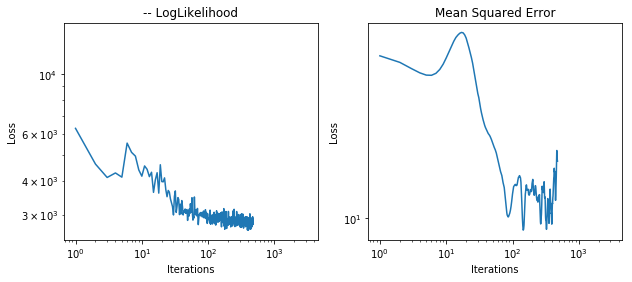

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(losses)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Iterations')
ax[0].set_title('-- LogLikelihood')

ax[1].plot(errors)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Iterations')
ax[1].set_title('Mean Squared Error')

Text(0.5,1,'Simulation')

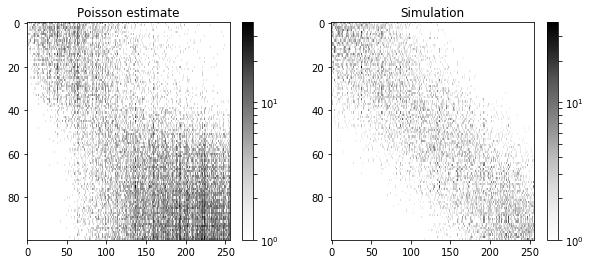

In [13]:
import matplotlib.colors as colors
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

u_ = sess.run(qU.mean())
v_ = sess.run(qV.mean())
theta_ = sess.run(qtheta.mean())
gamma_ = sess.run(qgamma.mean())
alpha_ = sess.run(qalpha.mean())

log_u = ((u_ @ v_ + theta_).T + gamma_.T + alpha_).T @ basis.T

etable = np.zeros((N, D))
for i in range(etable.shape[0]): 
    etable[i] = np.random.poisson(np.exp(log_u[i]))
img1 = ax[0].imshow(etable, aspect='auto', cmap='Greys', norm=colors.LogNorm())
fig.colorbar(img1, ax=ax[0])
ax[0].set_title('Poisson estimate')

img2 = ax[1].imshow(table.matrix_data.todense().T, aspect='auto', cmap='Greys', norm=colors.LogNorm())
fig.colorbar(img1, ax=ax[1])
ax[1].set_title('Simulation')

Text(0.5,1,'Estimated Theta')

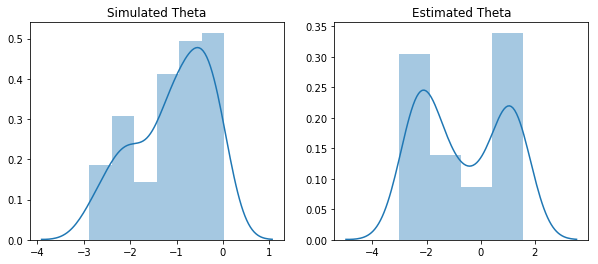

In [14]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(sim_theta, ax=ax[0])
sns.distplot(theta_, ax=ax[1])
ax[0].set_title('Simulated Theta')
ax[1].set_title('Estimated Theta')

Text(0.5,1,'Estimated Gamma')

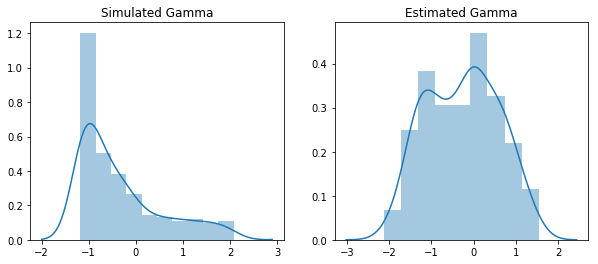

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(sim_gamma, ax=ax[0])
sns.distplot(gamma_, ax=ax[1])
ax[0].set_title('Simulated Gamma')
ax[1].set_title('Estimated Gamma')